In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2021,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
# portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
#                        ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
#                        ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
# portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
#                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
#                           ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
# portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
#                            ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
#                           ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
#                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
#                           ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
#                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
#                           ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vii = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
                          ,classifier_list.WEEKLY_CRYPTO_SPECULATION_CLASSIFIER
                          ,ranker_list.NONE)

portfolios = []
# portfolios.append(portfolio)
# portfolios.append(portfolio_ii)
# portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
portfolios.append(portfolio_v)
portfolios.append(portfolio_vi)
portfolios.append(portfolio_vii)


In [10]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [11]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [12]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [13]:
bench_returns

,year,week,adjclose,quarter,day,bench_weekly_return,quarter_start,bench_quarterly_return,weekly_variance,quarterly_variance
14,2013,40,1696.49,3.0,4.0,-0.009077,1619.09,0.047805,0.000181,0.000425
15,2013,41,1687.92,4.0,4.0,-0.005052,1687.92,0.000000,0.000162,0.000341
16,2013,42,1676.75,4.0,4.0,-0.006618,1687.92,-0.006618,0.000161,0.000376
17,2013,43,1721.48,4.0,4.0,0.026677,1687.92,0.019882,0.000166,0.000383
18,2013,44,1751.51,4.0,4.0,0.017444,1687.92,0.037674,0.000172,0.000379
...,...,...,...,...,...,...,...,...,...,...
517,2023,21,4159.00,2.0,4.0,0.007039,4105.13,0.013123,0.000164,0.000446
518,2023,22,4162.04,2.0,4.0,0.000731,4105.13,0.013863,0.000164,0.000248
519,2023,23,4222.19,2.0,4.0,0.014452,4105.13,0.028516,0.000092,0.000224
520,2023,24,4283.59,2.0,4.0,0.014542,4105.13,0.043472,0.000097,0.000247


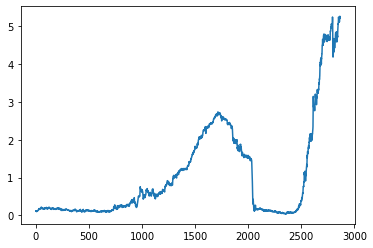

In [14]:
plt.plot(tyields["value"])

In [15]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("trades")
    trade["positions"] = int(portfolio.pricer_class.positions)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [16]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [17]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,market_return,buy_day,sell_day,risk,positions,portfolio,pricer_timeframe
0,2021,10,BTC,0.309877,1.0,1.117083,1.081683,0,1.081683,True,...,True,False,False,1.15,1,5,True,1,wcr_n_n_b_r,week
1,2021,12,BTC,0.241785,1.0,1.022554,1.022138,0,1.022138,True,...,True,False,False,1.15,1,5,True,1,wcr_n_n_b_r,week
2,2021,13,BTC,0.244062,1.0,0.977701,0.997299,0,0.997299,True,...,True,False,False,1.15,1,5,True,1,wcr_n_n_b_r,week
3,2021,32,BTC,0.165446,1.0,1.033167,1.032071,0,1.032071,True,...,True,False,False,1.15,1,5,True,1,wcr_n_n_b_r,week
4,2021,33,BTC,0.173666,1.0,1.094196,1.103507,0,1.103507,True,...,True,False,False,1.15,1,5,True,1,wcr_n_n_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2021,42,BTC,0.574399,1.0,0.955364,0.948163,0,0.948163,True,...,False,False,False,1.15,1,5,True,1,wcs_wcsc_n_b_r,week
26,2021,43,BTC,0.581243,1.0,1.025264,1.015823,0,1.015823,True,...,False,False,False,1.15,1,5,True,1,wcs_wcsc_n_b_r,week
27,2021,44,BTC,0.567271,1.0,0.973130,1.001591,0,1.001591,True,...,False,False,False,1.15,1,5,True,1,wcs_wcsc_n_b_r,week
28,2021,45,BTC,0.609300,1.0,0.962637,0.977528,0,0.977528,True,...,False,False,False,1.15,1,5,True,1,wcs_wcsc_n_b_r,week


In [18]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [19]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [20]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'portfolio',
 'pricer_timeframe']

In [21]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 58.81it/s]


In [22]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
14,True,True,False,False,False,1.15,1,5,True,wcs_wcsc_n_b_r,week,1.636102,-4.216804,0.105382,-0.150616
14,True,True,True,False,False,1.15,1,5,True,wcs_wcsc_n_b_r,week,1.636102,-4.216804,0.105382,-0.150616
11,True,True,True,False,False,1.15,1,5,True,wcr_n_n_b_r,week,1.412206,-8.633220,-0.824973,-0.047632
11,True,True,False,False,False,1.15,1,5,True,wcr_n_n_b_r,week,1.412206,-8.633220,-0.824973,-0.047632
10,True,True,True,False,False,1.15,1,5,True,wcw_n_n_b_r,week,1.340942,-1.248109,1.012746,-0.272378
10,True,True,False,False,False,1.15,1,5,True,wcw_n_n_b_r,week,1.340942,-1.248109,1.012746,-0.272378


In [23]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,pricer_timeframe,pv,beta,rrr,sharpe
0,wcr_n_n_b_r,True,True,True,False,False,1.15,1,5,True,week,1.412206,-8.633220,-0.824973,-0.047632
1,wcs_wcsc_n_b_r,True,True,False,False,False,1.15,1,5,True,week,1.636102,-4.216804,0.105382,-0.150616
2,wcw_n_n_b_r,True,True,True,False,False,1.15,1,5,True,week,1.340942,-1.248109,1.012746,-0.272378


In [24]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

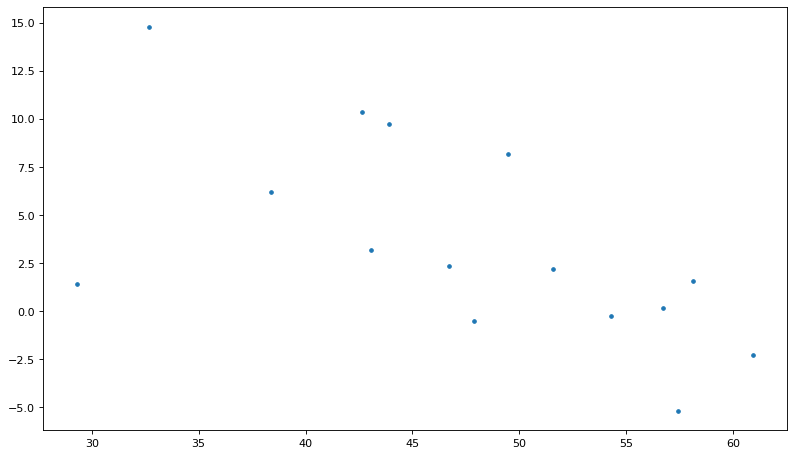

In [25]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [26]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2021,10,BTC,0.494735,1.0,1.081683,0,NaN,NaN
1,2021,12,BTC,0.515885,1.0,1.022138,0,NaN,NaN
2,2021,13,BTC,0.542887,1.0,0.997299,0,NaN,NaN
3,2021,30,BTC,0.292981,1.0,1.014413,0,NaN,NaN
4,2021,31,BTC,0.326606,1.0,1.147961,0,NaN,NaN
5,2021,32,BTC,0.430645,1.0,1.032071,0,NaN,NaN
6,2021,33,BTC,0.426179,1.0,1.103507,0,NaN,NaN
7,2021,34,BTC,0.467197,1.0,1.023555,0,NaN,NaN
8,2021,35,BTC,0.438989,1.0,1.097245,0,NaN,NaN
9,2021,38,BTC,0.383846,1.0,1.061800,0,NaN,NaN


In [27]:
ledger["actual_returns"].mean()

1.0346437928199614

In [28]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.7333333333333333

In [29]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [30]:
portfolio

position,year,week,0
0,2021,10,1.081683
1,2021,12,1.022138
2,2021,13,0.997299
3,2021,30,1.014413
4,2021,31,1.147961
5,2021,32,1.032071
6,2021,33,1.103507
7,2021,34,1.023555
8,2021,35,1.097245
9,2021,38,1.061800


In [31]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [32]:
cumulative

,0,year,week,pv,adjclose,bench,date_string,date
0,1.081683,2021,10,1.081683,3840.45,1.000000,2021-W10,2021-03-12
1,1.105629,2021,12,1.105629,3946.87,1.027710,2021-W12,2021-03-26
2,1.102643,2021,13,1.102643,3924.86,1.021979,2021-W13,2021-04-02
3,1.118535,2021,30,1.118535,4343.90,1.131091,2021-W30,2021-07-30
4,1.284034,2021,31,1.284034,4407.76,1.147720,2021-W31,2021-08-06
5,1.325214,2021,32,1.325214,4415.72,1.149792,2021-W32,2021-08-13
6,1.462384,2021,33,1.462384,4449.13,1.158492,2021-W33,2021-08-20
7,1.496830,2021,34,1.496830,4435.11,1.154841,2021-W34,2021-08-27
8,1.642389,2021,35,1.642389,4488.26,1.168681,2021-W35,2021-09-03
9,1.743889,2021,38,1.743889,4459.84,1.161281,2021-W38,2021-09-24


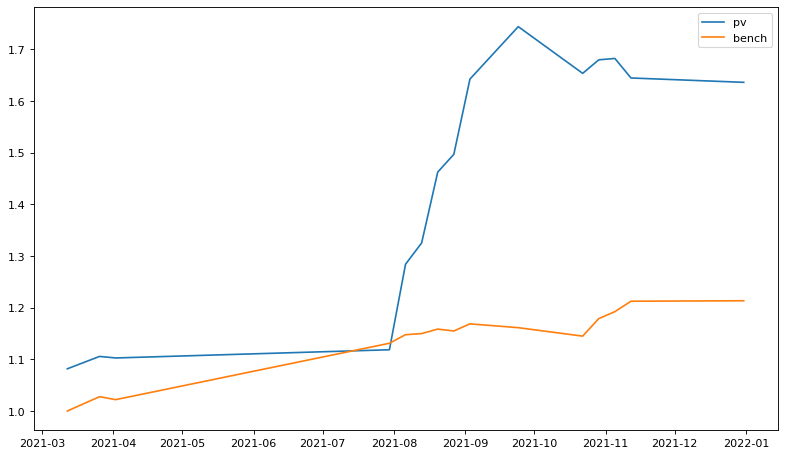

In [33]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [34]:
cumulative

,0,year,week,pv,adjclose,bench,date_string,date
0,1.081683,2021,10,1.081683,3840.45,1.000000,2021-W10,2021-03-12
1,1.105629,2021,12,1.105629,3946.87,1.027710,2021-W12,2021-03-26
2,1.102643,2021,13,1.102643,3924.86,1.021979,2021-W13,2021-04-02
3,1.118535,2021,30,1.118535,4343.90,1.131091,2021-W30,2021-07-30
4,1.284034,2021,31,1.284034,4407.76,1.147720,2021-W31,2021-08-06
5,1.325214,2021,32,1.325214,4415.72,1.149792,2021-W32,2021-08-13
6,1.462384,2021,33,1.462384,4449.13,1.158492,2021-W33,2021-08-20
7,1.496830,2021,34,1.496830,4435.11,1.154841,2021-W34,2021-08-27
8,1.642389,2021,35,1.642389,4488.26,1.168681,2021-W35,2021-09-03
9,1.743889,2021,38,1.743889,4459.84,1.161281,2021-W38,2021-09-24


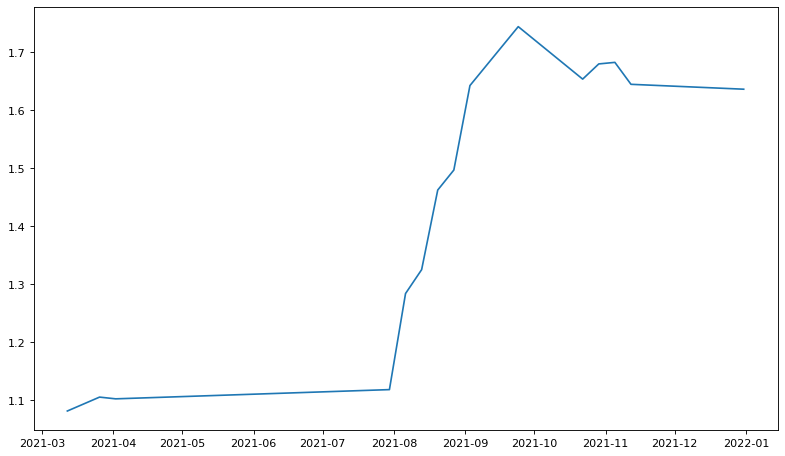

In [35]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [36]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,


In [37]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,weekly_delta,weekly_delta_sign,actual_returns,position
year,week,ticker,Security,,,,


In [38]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week
